In [ ]:
#Завдання 3 --------------------------------------------------------------

In [ ]:
# Задача класифікації текстів за допомогою рекурентної нейромережі.
# https://www.kaggle.com/datasets/tafadzwaz/emotion-classify-data

In [17]:
import pandas as pd
import string
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Завантаження даних
data = pd.read_csv('Emotion_classify_Data.csv', encoding='latin-1')

# Очищення тексту
def cleaning(value):
    punctuation_cleaning = []
    stopwords_cleaning_string = ''
    
    for i in value:
        if i not in string.punctuation:
            punctuation_cleaning.append(i)
    punctuation_cleaning = "".join(punctuation_cleaning).split()
    
    # Видалення стоп-слів (з використанням свого списку)
    stopwords_list = ["a", "an", "the", "in", "on", "at", "is", "it", "and", "to", "of"]
    for j in punctuation_cleaning:
        if j.lower() not in stopwords_list:
            stopwords_cleaning_string += j.lower() + ' '
    
    return stopwords_cleaning_string

data['Cleaned_Comment'] = data['Comment'].apply(cleaning)

In [18]:
# Перетворення емоцій у числовий формат
label_encoder = LabelEncoder()
data['Emotion_Label'] = label_encoder.fit_transform(data['Emotion'])

In [19]:
# Розподіл даних
X = data['Cleaned_Comment']
y = data['Emotion_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [20]:
# Токенізація тексту
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [21]:
# Вирівнювання послідовностей
maxlen = int(np.ceil(np.mean([len(x) for x in X_train_seq])))
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
total_words = len(tokenizer.word_index) + 1

In [22]:
# Створення моделі
model = Sequential()
model.add(Embedding(total_words, 32, input_length=maxlen))
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Компіляція моделі
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Навчання моделі
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3293 - loss: 1.0984 - val_accuracy: 0.3926 - val_loss: 1.0915
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5396 - loss: 1.0195 - val_accuracy: 0.6316 - val_loss: 0.7723
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7373 - loss: 0.6351 - val_accuracy: 0.8032 - val_loss: 0.5539
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8889 - loss: 0.3655 - val_accuracy: 0.8453 - val_loss: 0.4270
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9465 - loss: 0.2071 - val_accuracy: 0.8368 - val_loss: 0.4157
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9719 - loss: 0.1305 - val_accuracy: 0.8537 - val_loss: 0.4094
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9721 - loss: 0.1146 - val_accuracy: 0.8474 - val_loss: 0.4284
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9892 - loss: 0.0708 - val_accuracy: 0.8421 - val

In [23]:
# Оцінка моделі
results = model.evaluate(X_test_pad, y_test, verbose=0)
print('Losses:', results[0])
print('Accuracy:', results[1])

Losses: 0.45222777128219604
Accuracy: 0.8594276309013367


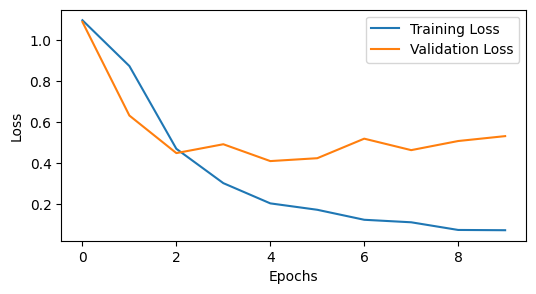

In [10]:
# Візуалізація результатів
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()


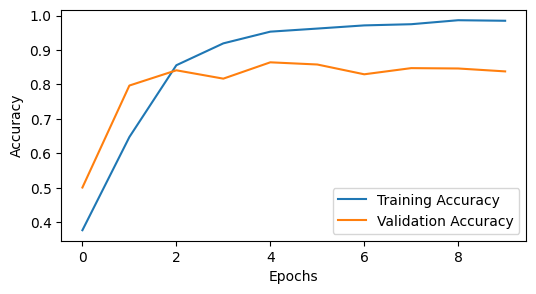

In [11]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()